In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import random
import re
from scipy import stats
sns.set()
from google.colab import files
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, r2_score, mean_squared_error, f1_score, auc
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA as sk_PCA
from sklearn.pipeline import Pipeline
import tqdm
from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances_argmin
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock, euclidean


In [ ]:
rng = 12147337
random.seed(rng)
alpha = 0.05
drive.mount('/content/drive')
raw_song_data = pd.read_csv('/content/drive/MyDrive/1001project/spotify52kData.csv')
for column in raw_song_data.columns:
    if raw_song_data[column].dtype == 'int64' or raw_song_data[column].dtype == 'float64':
        raw_song_data[column] = pd.to_numeric(raw_song_data[column], errors='coerce')

raw_rating_data = pd.read_csv('/content/drive/MyDrive/1001project/starRatings.csv')
raw_rating_data = raw_rating_data.apply(pd.to_numeric, errors='coerce')

def cohens_d(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1, ddof=1)**2 + np.std(group2, ddof=1)**2) / 2)
    d = mean_diff / pooled_std
    return d

Mounted at /content/drive


# 新段落

In [ ]:
# preprocessing
# Imputed missing values
# Note that the data in the capstone project has commas and pound signs, so you'll have to handle that (literal csv as in comma separated values might have issues).
# if there are skewed distributions, extreme values might also have to be handled.

original_indices = raw_song_data.index.tolist()
subset_columns = ['duration', 'energy', 'key', 'artists', 'danceability','track_name','explicit','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']
# Sort the data by popularity in descending order within each group of duplicates
processed_song_data = raw_song_data.sort_values(by=subset_columns + ['popularity'], ascending=[True] * len(subset_columns) + [False], inplace=False)
# Drop duplicates based on the defined subset, keeping the one with the highest popularity
processed_song_data = processed_song_data.drop_duplicates(subset=subset_columns, keep='first', inplace=False)
new_indices = processed_song_data.index.tolist()
removed_indices = list(set(original_indices) - set(new_indices))
removed_indices = [idx for idx in removed_indices if idx <= 5000]
processed_rating_data = raw_rating_data.drop(raw_rating_data.columns[removed_indices], axis=1, inplace=False)
print(f"We removed {52000-len(processed_song_data)} duplications")


We removed 9064 duplications


In [ ]:
processed_rating_data

,NaN,NaN.1,NaN.2,NaN.3,NaN.4,NaN.5,NaN.6,NaN.7,NaN.8,NaN.9,...,NaN.4461,NaN.4462,NaN.4463,NaN.4464,NaN.4465,NaN.4466,NaN.4467,NaN.4468,NaN.4469,NaN.4470
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,0.0
2,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


RMSE: 2.520134548620071
R-squared: 7.561259876553983e-05
Coefficient(weight and intercept): (array([-0.03897506]), 5.6434409281314775)


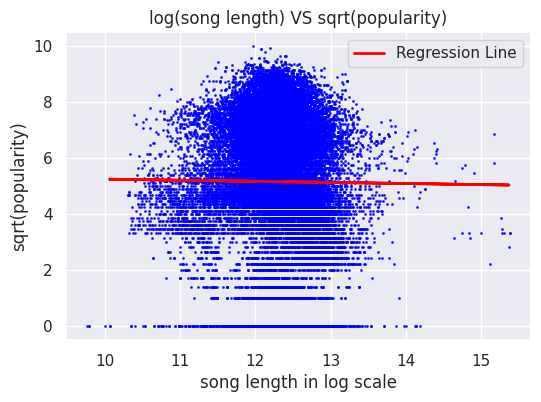

The pearon's correlation coefficient is: -0.00792555699099863
pvalue is 0.07071707464362775
It is not significant, they are uncorrelated


In [ ]:
# 1) Is there a relationship between song length and popularity of a song? If so, is it positive or negative?
#using linear regression to find relationship
popularity, duration = raw_song_data['popularity'], raw_song_data['duration']
#duration is highly skewed, the log will make it like normal and symmetric
#sqrt will give popluarity more like normal
popularity, duration = np.sqrt(popularity), np.log(duration)
#build linear regression
X = duration.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, popularity, test_size=0.2, random_state=rng)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared
print(f"RMSE: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
print(f"Coefficient(weight and intercept): {model.coef_, model.intercept_}")
#plot
plt.figure(figsize=(6, 4))
plt.scatter(duration,popularity, color='blue', alpha=0.8, s=1)
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')  # Regression line
plt.ylabel('sqrt(popularity)')
plt.xlabel('song length in log scale')
plt.title('log(song length) VS sqrt(popularity)')
plt.legend()
plt.savefig("1.png")
#files.download("1.png")
plt.show()
#permutation test on pearon's correlation coefficient
correlation_coefficient = popularity.corr(duration)
print(f"The pearon's correlation coefficient is: {correlation_coefficient}")
#method = stats.PermutationMethod(n_resamples=5000, random_state=rng)
p = stats.pearsonr(popularity, duration)[1]
print(f'pvalue is {p}')
if p > alpha:
  print("It is not significant, they are uncorrelated")

Number of NaN values:0
Difference of variance:0.05196877365813268


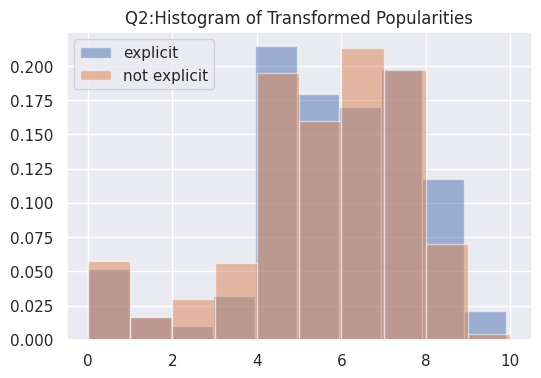

pvalue:3.2260950156513524e-19
Significant
Cohen's d: 0.13655692727538568


In [ ]:
# 2) Are explicitly rated songs more popular than songs that are not explicit?
explicit, no_explicit = processed_song_data["explicit"] == True , processed_song_data["explicit"] == False
explicit_popularity, explicit_no_popularity = processed_song_data[explicit]['popularity'], processed_song_data[no_explicit]['popularity']
print(f'Number of NaN values:{explicit_popularity.isna().sum() + explicit_no_popularity.isna().sum()}')
#transformation???
explicit_popularity, explicit_no_popularity = np.sqrt(explicit_popularity), np.sqrt(explicit_no_popularity)
print(f'Difference of variance:{abs(np.var(explicit_no_popularity) - np.var(explicit_popularity))}')
#plot
plt.figure(figsize=(6, 4))
plt.hist(explicit_popularity, density=True, alpha=0.5,label="explicit")
plt.hist(explicit_no_popularity, density=True, alpha=0.5,label="not explicit")
#plt.axvline(np.mean(explicit_popularity), color='blue', linestyle='dashed', linewidth=2, label=f'explicit mean{np.mean(explicit_popularity):.2f}')
#plt.axvline(np.mean(explicit_no_popularity), color='pink', linestyle='dashed', linewidth=2, label=f'not explicit mean{np.mean(explicit_no_popularity):.2f}')
plt.legend()
plt.title("Q2:Histogram of Transformed Popularities")
plt.savefig("2.png")
# files.download("2.png")
plt.show()
# variance are different
# perform welch t-test
stat,p = stats.ttest_ind(explicit_popularity, explicit_no_popularity, equal_var = True, alternative='greater')
print(f'pvalue:{p}')
if p < alpha:
  print("Significant")
# since sample size is too large, we consider the cohen's d effect size
effect_size = cohens_d(explicit_popularity, explicit_no_popularity)
print("Cohen's d:", effect_size)

Number of NaN values:0
Difference of variance:0.02779797391881811


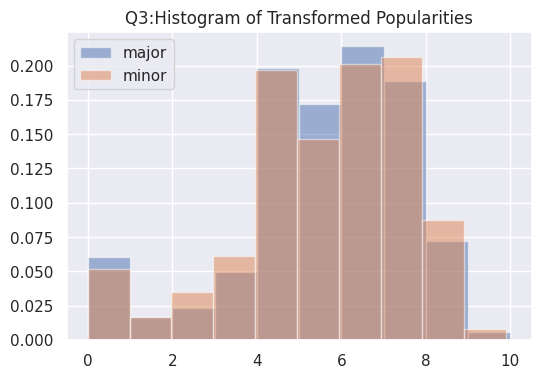

pvalue:0.002826625689309152
Significant
Cohen's d: -0.02756984133467036


In [ ]:
#3) Are songs in major key more popular than songs in minor key?
major, minor = processed_song_data["mode"] == 1 , processed_song_data["mode"] == 0
major_popularity, minor_popularity = processed_song_data[major]['popularity'], processed_song_data[minor]['popularity']
#transformation???
major_popularity, minor_popularity = np.sqrt(major_popularity), np.sqrt(minor_popularity)
print(f'Number of NaN values:{major_popularity.isna().sum() + minor_popularity.isna().sum()}')
print(f'Difference of variance:{abs(np.var(major_popularity) - np.var(minor_popularity))}')
#plot
plt.figure(figsize=(6, 4))
plt.hist(major_popularity, density=True , alpha=0.5,label="major")
plt.hist(minor_popularity, density=True, alpha=0.5,label="minor")
# plt.axvline(np.mean(major_popularity), color='blue', linestyle='dashed', linewidth=2, label=f'major mean{np.mean(major_popularity):.2f}')
# plt.axvline(np.mean(minor_popularity), color='pink', linestyle='dashed', linewidth=2, label=f'minor mean{np.mean(minor_popularity):.2f}')
plt.legend()
plt.title("Q3:Histogram of Transformed Popularities")
plt.savefig("3.png")
# files.download("3.png")
plt.show()
# variance are different
# perform welch t-test
stat,p = stats.ttest_ind(major_popularity, minor_popularity, equal_var = False)
print(f'pvalue:{p/2}')
if p < alpha:
  print("Significant")
# since sample size is too large, we consider the cohen's d effect size
effect_size = cohens_d(major_popularity, minor_popularity)
print("Cohen's d:", effect_size)

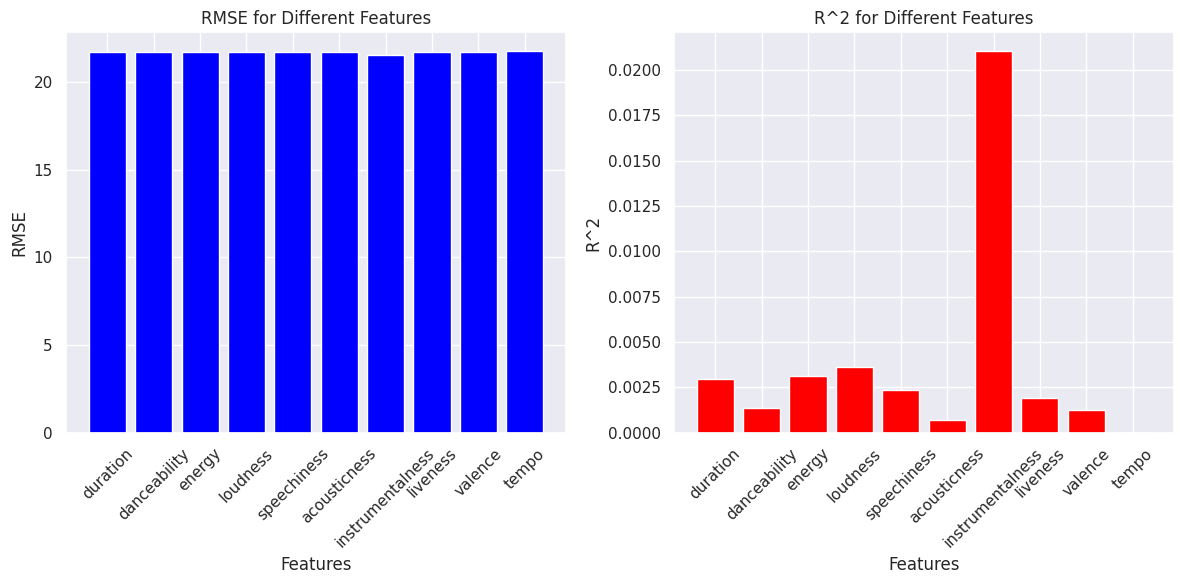

            Feature       RMSE       R^2
0          duration  21.710992  0.002987
1      danceability  21.728472  0.001381
2            energy  21.709459  0.003128
3          loudness  21.704039  0.003625
4       speechiness  21.717865  0.002355
5      acousticness  21.736005  0.000688
6  instrumentalness  21.513783  0.021017
7          liveness  21.722577  0.001922
8           valence  21.729574  0.001279
9             tempo  21.743412  0.000007


In [ ]:
#4
# Load the datasets
features = ['duration', 'danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
rmse_values = []
r2_values = []

# Placeholder for code to perform linear regression for each feature
for feature in features:
    X = processed_song_data[[feature]] # Feature data
    y = processed_song_data['popularity'] # Target data

    # Creating and fitting the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predictions
    y_pred = model.predict(X)

    # Calculating MSE and R^2
    rmse = mean_squared_error(y, y_pred,squared = False)
    r2 = r2_score(y, y_pred)

    # Append results to lists
    rmse_values.append(rmse)
    r2_values.append(r2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting RMSE values
ax1.bar(features, rmse_values, color='blue')
ax1.set_title('RMSE for Different Features')
ax1.set_xlabel('Features')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)

# Plotting R^2 values
ax2.bar(features, r2_values, color='red')
ax2.set_title('R^2 for Different Features')
ax2.set_xlabel('Features')
ax2.set_ylabel('R^2')
ax2.tick_params(axis='x', rotation=45)

# Adjusting layout for better display
plt.tight_layout()
plt.show()

# Creating a dataframe for results
results_df = pd.DataFrame({'Feature': features, 'RMSE': rmse_values, 'R^2': r2_values})

# Displaying the results dataframe
print(results_df)


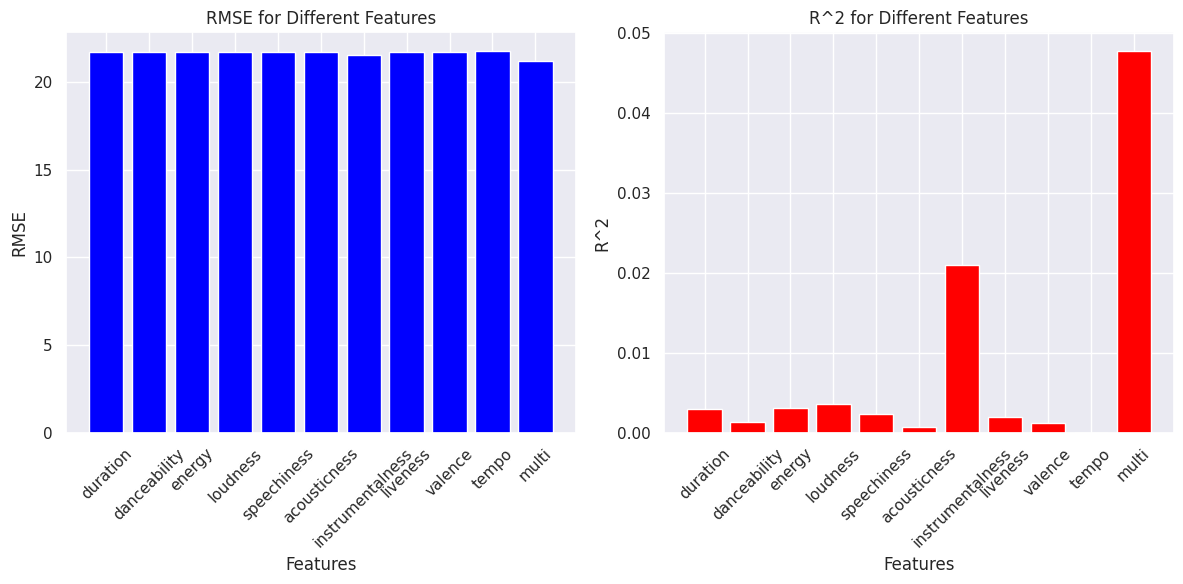

             Feature       RMSE       R^2
0           duration  21.710992  0.002987
1       danceability  21.728472  0.001381
2             energy  21.709459  0.003128
3           loudness  21.704039  0.003625
4        speechiness  21.717865  0.002355
5       acousticness  21.736005  0.000688
6   instrumentalness  21.513783  0.021017
7           liveness  21.722577  0.001922
8            valence  21.729574  0.001279
9              tempo  21.743412  0.000007
10             multi  21.218796  0.047680


In [ ]:
#5
# Defining the features and target variable
X_multi = processed_song_data[features]
y_multi = processed_song_data['popularity']

# Creating and fitting the multiple linear regression model
model_multi = LinearRegression()
model_multi.fit(X_multi, y_multi)

# Predicting popularity
y_pred_multi = model_multi.predict(X_multi)

# Calculating MSE and R^2 for the multiple regression model
rmse_multi = mean_squared_error(y_multi, y_pred_multi,squared = False)
r2_multi = r2_score(y_multi, y_pred_multi)

rmse_values.append(rmse_multi)
r2_values.append(r2_multi)
features_tempo = features.copy()
features_tempo.append('multi')



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting MSE values
ax1.bar(features_tempo, rmse_values, color='blue')
ax1.set_title('RMSE for Different Features')
ax1.set_xlabel('Features')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)

# Plotting R^2 values
ax2.bar(features_tempo, r2_values, color='red')
ax2.set_title('R^2 for Different Features')
ax2.set_xlabel('Features')
ax2.set_ylabel('R^2')
ax2.tick_params(axis='x', rotation=45)

# Adjusting layout for better display
plt.tight_layout()
plt.show()


# Creating a dataframe for results
results_df = pd.DataFrame({'Feature': features_tempo, 'RMSE': rmse_values, 'R^2': r2_values})

# Displaying the results dataframe
print(results_df)


In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

# Ridge
ridge = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge.fit(X_multi, y_multi)

# predict
y_pred = ridge.predict(X_multi)
rmse_ridge = mean_squared_error(y_multi, y_pred, squared=False)

# Get the best lambda (alpha) and R^2
best_lbd_ridge = ridge.alpha_
best_r2_ridge = ridge.score(X_multi, y_multi)

#result
rmse_ridge,best_lbd_ridge,best_r2_ridge

# LASSO
lasso = LassoCV(alphas=np.logspace(-6, 6, 13))
lasso.fit(X_multi, y_multi)

# predict
y_pred = lasso.predict(X_multi)
rmse_lasso = mean_squared_error(y_multi, y_pred, squared=False)

# Get the best lambda (alpha) and R^2
best_lbd_lasso = lasso.alpha_
best_r2_lasso = lasso.score(X_multi, y_multi)

# result
rmse_lasso,best_lbd_lasso,best_r2_lasso,rmse_ridge,best_lbd_ridge,best_r2_ridge



NameError: ignored

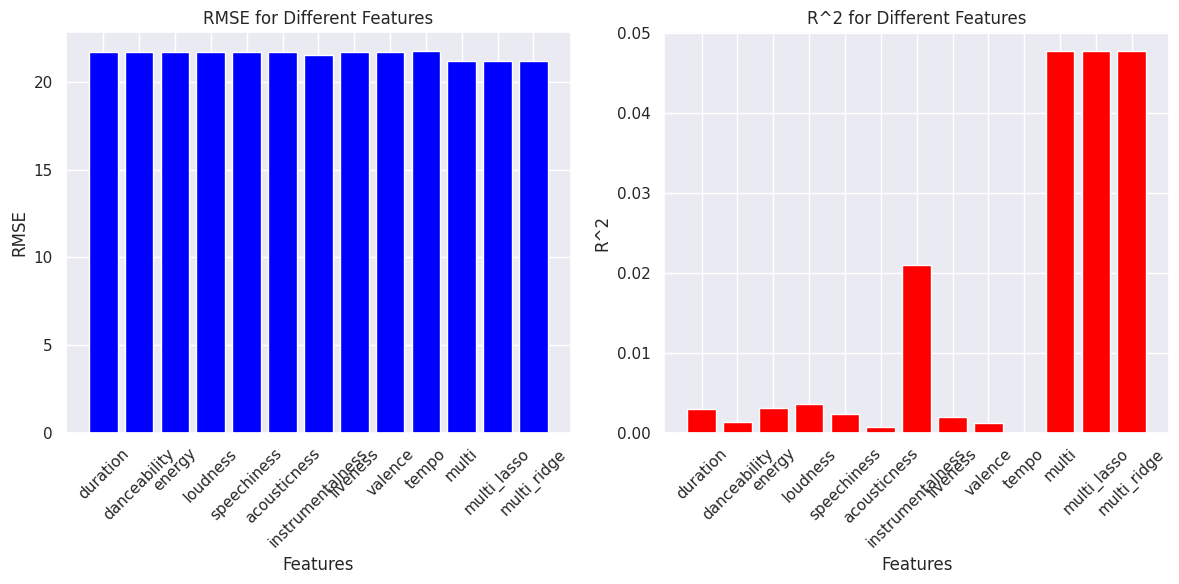

             Feature       RMSE       R^2
0           duration  21.710992  0.002987
1       danceability  21.728472  0.001381
2             energy  21.709459  0.003128
3           loudness  21.704039  0.003625
4        speechiness  21.717865  0.002355
5       acousticness  21.736005  0.000688
6   instrumentalness  21.513783  0.021017
7           liveness  21.722577  0.001922
8            valence  21.729574  0.001279
9              tempo  21.743412  0.000007
10             multi  21.218796  0.047680
11       multi_lasso  21.218796  0.047680
12       multi_ridge  21.218808  0.047679


In [ ]:
rmse_values.append(rmse_lasso)
r2_values.append(best_r2_lasso)
features_tempo.append('multi_lasso')
rmse_values.append(rmse_ridge)
r2_values.append(best_r2_ridge)
features_tempo.append('multi_ridge')



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting RMSE values
ax1.bar(features_tempo, rmse_values, color='blue')
ax1.set_title('RMSE for Different Features')
ax1.set_xlabel('Features')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)

# Plotting R^2 values
ax2.bar(features_tempo, r2_values, color='red')
ax2.set_title('R^2 for Different Features')
ax2.set_xlabel('Features')
ax2.set_ylabel('R^2')
ax2.tick_params(axis='x', rotation=45)

# Adjusting layout for better display
plt.tight_layout()
plt.show()

# Creating a dataframe for results
results_df = pd.DataFrame({'Feature': features_tempo, 'RMSE': rmse_values, 'R^2': r2_values})

# Displaying the results dataframe
print(results_df)

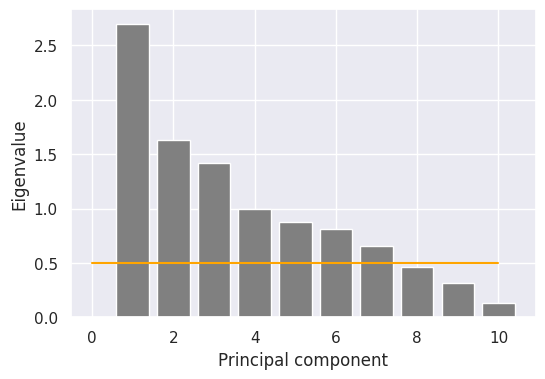

Variance explained by the 7 PCs above is: 90.867 


In [ ]:
#6
features = ['duration','danceability', 'energy', 'loudness', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = processed_song_data[features].values
pca_pipeline = Pipeline([('scaling', StandardScaler()), ('pca', sk_PCA())])
pca_pipeline.fit(X)
eigVals=pca_pipeline[1].explained_variance_
nComponents = 10
x = np.linspace(1,nComponents, nComponents)
plt.figure(figsize=(6, 4))
plt.bar(x, eigVals, color='gray')
plt.plot([0,nComponents],[.5,.5],color='orange') # Orange Kaiser criterion line for the fox
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.show()
covarExplained = eigVals/sum(eigVals)*100
print("Variance explained by the 7 PCs above is: %.3f " % (sum(covarExplained[:7])))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

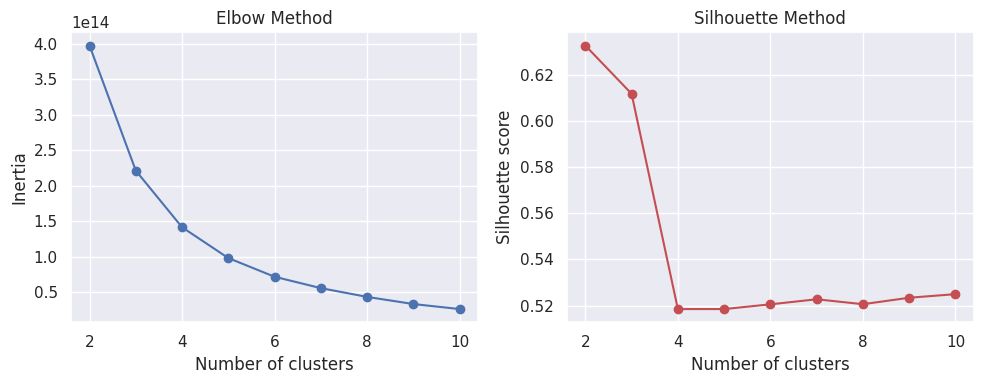

In [ ]:

# Applying PCA with 7 components
pca_7 = sk_PCA(n_components=7)
X_pca = pca_7.fit_transform(X)

# Elbow and Silhouette methods to determine the optimal number of clusters
range_n_clusters = range(2, 11)
elbow = []
silhouette = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=rng)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The average silhouette_score is used to assess the homogeneity within clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette.append(silhouette_avg)

    # The inertia is the sum of squared distances of samples to their closest cluster center
    elbow.append(clusterer.inertia_)

# Plotting Elbow Method
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, elbow, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plotting Silhouette Method
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.tight_layout()
plt.show()

ValueError: ignored

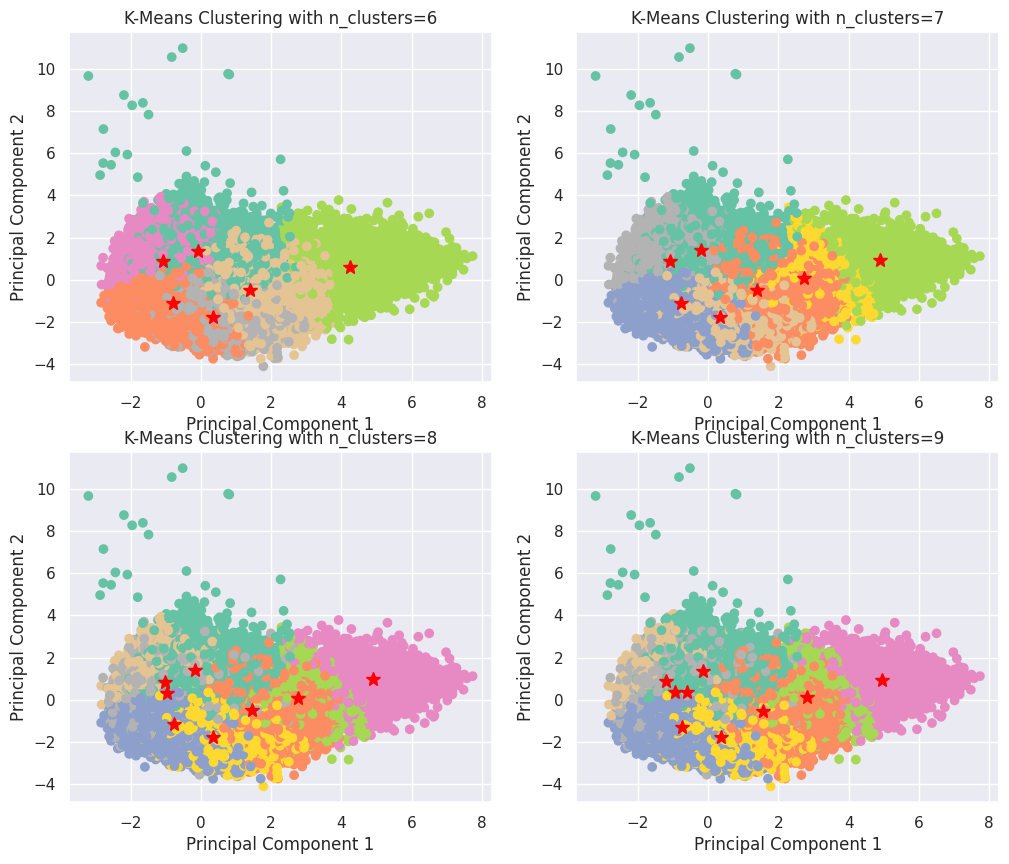

In [ ]:
#6

def KMeans(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
#     print(i.shape)
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers

    # Compute L1 and Euclidean within-cluster distances
    total_within_cluster_L1_distance = 0
    total_within_cluster_euclidean_distance = 0
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        for point in cluster_points:
            total_within_cluster_L1_distance += cityblock(point, centers[i])
            total_within_cluster_euclidean_distance += euclidean(point, centers[i])

    return centers, labels, total_within_cluster_L1_distance, total_within_cluster_euclidean_distance


l1_distances = []
euclidean_distances = []
X_transformed = pca_pipeline.transform(X)
### Let's Cluster K-Means for the  data used above
n_clusters=range(6,11)
plt.figure(figsize=(12, 10))
for i, c_num in enumerate(n_clusters):
    centers, labels, total_L1, total_euclidean = KMeans(X_transformed, c_num)

    # Store the distances
    l1_distances.append(total_L1)
    euclidean_distances.append(total_euclidean)

    #visualization
    plt.subplot(2, 2, i+1)
    plt.title('K-Means Clustering with n_clusters={}'.format(c_num))
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels, cmap='Set2')
    plt.plot(centers[:, 0], centers[:, 1], '*',markersize=10,color='red')


for i, c_num in enumerate(n_clusters):
    print(f"n_clusters={c_num}: L1 Distance = {l1_distances[i]}, Euclidean Distance = {euclidean_distances[i]}")


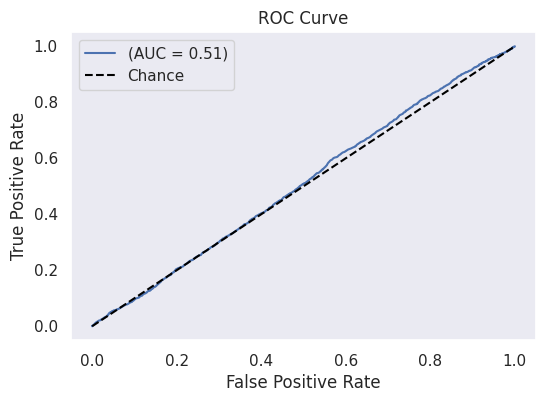

AUC for logistics: 0.5102627193019724
Logistics Model Coefficient betas(weights and intercept): (array([[0.07198345]]), array([0.46907827]))

AUC for SVM: 0.4895775114224339


In [ ]:
#7
X = processed_song_data['valence'].values.reshape(-1,1)
y = processed_song_data['mode'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)
model = LogisticRegression(max_iter=1000, random_state=rng)
svm_model = SVC(probability=True, random_state=rng)
model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'(AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.legend()
plt.grid()
plt.savefig(f'7_ROC.png')
#files.download(f'{movie}_ROC.png')
plt.show()

# # Generate X values to plot the logistic regression curve
# x_values = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
# #Predict probabilities for positive class (class 1)
# y_hat2 = model.predict_proba(x_values)[:, 1]
# plt.figure(figsize=(6, 4))
# plt.plot(x_values, y_hat2, color='red', label='Logistic Regression',linewidth=4)
# plt.scatter(X, y, color='blue', label='Data Points', alpha=0.3,s=1)
# plt.xlabel('Valence')
# plt.ylabel('Major or Minor')
# plt.title(f'Logistic Regression Curve')
# plt.legend()
# plt.grid()
# plt.savefig(f'7logistic.png')
# #files.download(f'{movie}.png')
# plt.show()

# Printing AUC and model coefficients
print(f"AUC for logistics: {auc}")
print(f"Logistics Model Coefficient betas(weights and intercept): {model.coef_,model.intercept_}\n")

y_pred_prob = svm_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC for SVM: {auc}")

In [ ]:
y = processed_song_data['mode'].values
for i,column in enumerate(processed_song_data.columns):
    if i not in [0,1,2,3,6,9,11,19]:
        X = processed_song_data[column].values.reshape(-1,1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model = LogisticRegression(max_iter=1000, random_state=rng)
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_prob)
        print(f"AUC with {column}: {auc}")

AUC with popularity: 0.5056688901994901
AUC with duration: 0.533060361398795
AUC with danceability: 0.5439942099244581
AUC with energy: 0.5552537819913552
AUC with loudness: 0.5302717112370344
AUC with speechiness: 0.557107284779543
AUC with acousticness: 0.5608392904325082
AUC with instrumentalness: 0.5406053845136058
AUC with liveness: 0.5124167143402232
AUC with valence: 0.5102627193019724
AUC with tempo: 0.5097992496740019
AUC with time_signature: 0.5096960412653287


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

features = ['popularity', 'duration', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
#features = ['danceability', 'energy','loudness', 'speechiness','acousticness', 'instrumentalness']
target = 'mode'

X = processed_song_data[features].values
y = processed_song_data[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.norm = nn.LayerNorm(32)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.norm(x)
        x = torch.sigmoid(self.fc4(x))
        return x

input_size = len(features)
model = NeuralNetwork(input_size).to(device)
model.train()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 10000
for epoch in tqdm(range(epochs)):
    outputs = model(X_train_tensor)
    # print(outputs.shape)
    # print(y_train_tensor.view(-1, 1).shape)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = torch.round(outputs)
    accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy())
    auc = roc_auc_score(y_test, predicted.cpu())
    print(f"Accuracy of Neural Network: {accuracy}")
    print(f"AUC of Neural Network: {auc}")


Accuracy of Neural Network: 0.6864229156963204
AUC of Neural Network: 0.6333141078409085


In [ ]:
#8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
features = ['duration','danceability', 'energy', 'loudness', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
target = 'track_genre'
X = processed_song_data[features].values
#PCA
pca_pipeline = Pipeline([('scaling', StandardScaler()), ('pca', sk_PCA(n_components=7))])
X_transformed = pca_pipeline.fit_transform(X)

y = processed_song_data[target].values.reshape(-1,1)
#label Y
label_encoder = LabelEncoder()
scaler = StandardScaler()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=rng)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.dropout = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128, output_size)
        self.norm = nn.LayerNorm(128)
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.norm(x)
        x = self.soft(self.fc4(x))
        return x

# Create an instance of the neural network
input_size = 10
output_size = len(label_encoder.classes_)
model = NeuralNetwork(input_size, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

model.train()
epochs = 5000
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    # print(outputs.dtype)
    # print(y_train_tensor.dtype)
    y_train_tensor=y_train_tensor.to(torch.int64)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy())
    f1 = f1_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy(), average='weighted')
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy of Neural Network: {accuracy:.4f}")
    roc_dict = dict()
    fpr = dict()
    tpr = dict()
    # Convert outputs to probabilities using softmax
    probs = torch.softmax(outputs, dim=1).cpu().numpy()

    # Compute ROC curve and ROC area for each class
    for i in range(output_size):
        fpr[i], tpr[i], _ = roc_curve((y_test_tensor.cpu().numpy() == i).astype(int), probs[:, i])
        roc_dict[i] = metrics.auc(fpr[i], tpr[i])


F1 Score: 0.2282
Accuracy of Neural Network: 0.2939


In [ ]:
label_mapping = pd.DataFrame({
    'Genre': label_encoder.inverse_transform(label_encoder.transform(label_encoder.classes_)),
    "AUC": [roc_dict[i] for i in range(output_size)]
})

from tabulate import tabulate

# Print the label mapping table with ROC AUC values in separate columns
print(tabulate(label_mapping, headers='keys', tablefmt='pretty'))


+----+----------------+--------------------+
|    |     Genre      |        AUC         |
+----+----------------+--------------------+
| 0  |    acoustic    | 0.6984806770674009 |
| 1  |    afrobeat    | 0.6661460304373682 |
| 2  |    alt-rock    | 0.678952315067153  |
| 3  |  alternative   | 0.5832953588695328 |
| 4  |    ambient     | 0.755745910055271  |
| 5  |     anime      | 0.5538288373661351 |
| 6  |  black-metal   | 0.7623261828563647 |
| 7  |   bluegrass    | 0.8080382020958989 |
| 8  |     blues      | 0.6265516971113921 |
| 9  |     brazil     | 0.6665336518672353 |
| 10 |   breakbeat    | 0.7047378848061552 |
| 11 |    british     | 0.5578026385466649 |
| 12 |    cantopop    | 0.8018761668761929 |
| 13 | chicago-house  | 0.7985503792843243 |
| 14 |    children    | 0.7575218905892863 |
| 15 |     chill      | 0.730375318346449  |
| 16 |   classical    | 0.7249353568393835 |
| 17 |      club      | 0.6663086159799682 |
| 18 |     comedy     | 0.8930228191328405 |
| 19 |    

 For 9 and 10 we are going to use raw data since different users have different rating for different songs.
 In the context of the capstone project, repeated track_names in starRatings.csv might arise from variations like explicit content, live performances, or other factors. It's essential to consider these differences when interpreting the data, as they could influence user ratings. You might choose to average these ratings, treating variations as separate entities, or explore ways to consolidate them based on your analytical approach.

R-squared: 0.24972815611119226
Coefficient(weight and intercept): (array([20.21554831]), -6.707631250016938)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

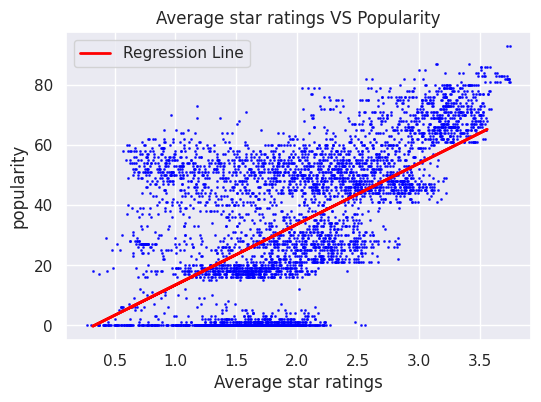

The spearman correlation coefficient is: 0.5434743580977026
pvalue is 0.0
significant, they are correlated


In [ ]:
#9
#a) Is there a relationship between popularity and average star rating for the 5k songs we have explicit feedback for?
average_star_ratings = raw_rating_data.mean(axis=0, skipna=True)
first_5k_popularity = raw_song_data['popularity'][0:5000]
#build linear regression
X = average_star_ratings.values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, first_5k_popularity, test_size=0.2, random_state=rng)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)  # R-squared
print(f"R-squared: {r2}")
print(f"Coefficient(weight and intercept): {model.coef_, model.intercept_}")
#plot
plt.figure(figsize=(6, 4))
plt.scatter(average_star_ratings,first_5k_popularity, color='blue', alpha=0.8, s=1)
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')  # Regression line
plt.ylabel('popularity')
plt.xlabel('Average star ratings')
plt.title('Average star ratings VS Popularity')
plt.legend()
plt.savefig("9a.png")
files.download("9a.png")
plt.show()
# cannot assume linearity, so use the spearmans correlations
# hypothesis test on spearmans correlation coefficient
res = stats.spearmanr(average_star_ratings, first_5k_popularity)
print(f"The spearman correlation coefficient is: {res.statistic}")
# method = stats.PermutationMethod(n_resamples=5000, random_state=rng)
p = res.pvalue
print(f'pvalue is {p}')
if p > alpha: print("It is not significant, they are uncorrelated")
else:  print("significant, they are correlated")

In [ ]:
#9b) Which 10 songs are in the “greatest hits” (out of the 5k songs), on the basis of the popularity based model?
sorted_songs_by_popularity = raw_song_data[0:5000].sort_values(by='popularity', ascending=False)
ten_greatest_hits = sorted_songs_by_popularity.drop_duplicates(subset=sorted_songs_by_popularity.columns.difference(['track_genre','songNumber'])).head(10)
print(ten_greatest_hits['track_name'])

2003      Sweater Weather
3300             Miss You
2000         Daddy Issues
2106       Mr. Brightside
3004              abcdefu
2002             Softcore
3006           In the End
2053                Creep
3569             Everlong
3217    Seven Nation Army
Name: track_name, dtype: object


In [ ]:
#10
raw_rating_data.columns = range(len(raw_rating_data.columns))#starRating data is mess, rowname and col
# precision, recall, F1 score
# use item-based collaborating
# Select a subset of items (songs) for evaluation and recommendation
n_items = 5000  # Adjust this number as needed
raw_ratings_subset = raw_rating_data.iloc[:, :n_items]

# Compute cosine similarity matrix for items in the subset
item_similarity_matrix = cosine_similarity(raw_rating_data.fillna(0).iloc[:, :n_items])

In [ ]:
def item_based_recommendations(user_id, n_recommendations=10):
    # Calculate predicted ratings for the user
    predicted_ratings = raw_ratings_subset.copy()

    for i in range(len(predicted_ratings.columns)): #each song
        if np.isnan(predicted_ratings.iloc[user_id, i]):
            #print("in")
            # Calculate predicted rating for unrated items based on item similarity
            similarity_scores = item_similarity_matrix[i] #find similar song by similarity
            rated_items = raw_ratings_subset.iloc[user_id].notnull() #predict not rated song by rated and related song
            rated_indices = np.where(rated_items == True)[0]
            prediction = np.dot(similarity_scores[rated_indices], raw_ratings_subset.iloc[user_id, rated_indices]) / similarity_scores[rated_indices].sum()
            predicted_ratings.iloc[user_id, i] = prediction

    # Get top N recommended items (songs)
    recommendations = predicted_ratings.iloc[user_id].sort_values(ascending=False).head(n_recommendations)
    return recommendations

def evaluate_recommendation_system():
    # Randomly select a user for evaluation (change this as needed)
    test_user_id = 6

    # Get actual ratings of the test user
    actual_ratings = raw_ratings_subset.iloc[test_user_id]
    #print(actual_ratings)
    # Get recommended songs for the test user
    recommended_songs = item_based_recommendations(test_user_id)
    #print(min(recommended_songs.values))
    #print(recommended_songs)
    # print(recommended_songs.index)
    # Create binary relevance vectors based on the recommended songs
    binary_relevance = actual_ratings.index.isin(recommended_songs.index).astype(int)
    #print(binary_relevance)
    # Calculate precision, recall, and F1 score
    tp = np.sum(binary_relevance)
    fp = len(recommended_songs) - tp
    AP = actual_ratings[actual_ratings >= min(recommended_songs.values)]
    #print(np.sum(actual_ratings))
    fn = np.sum(AP) - tp
    #print(tp,fp,fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    keys = np.fromiter(recommended_songs.keys(), dtype=int)
    for i in keys:
      print(raw_song_data[raw_song_data['songNumber']==i]['track_name'])
    return precision, recall, f1_score

# Evaluate the recommendation system
precision, recall, f1_score = evaluate_recommendation_system()

# Display the evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

1502    Victory
Name: track_name, dtype: object
2464    On And On
Name: track_name, dtype: object
3703    broken
Name: track_name, dtype: object
1653    I Don't Wanna Stop
Name: track_name, dtype: object
4104    Cold
Name: track_name, dtype: object
3135    O Come All Ye Faithful
Name: track_name, dtype: object
1611    Stay Here
Name: track_name, dtype: object
4115    The Last of Us
Name: track_name, dtype: object
288    12:51
Name: track_name, dtype: object
291    Brand New
Name: track_name, dtype: object
Precision: 1.0
Recall: 0.016891891891891893
F1 Score: 0.03322259136212625


In [ ]:
#EC

X = processed_song_data['loudness'].values.reshape(-1, 1)
y = processed_song_data['energy'].values.reshape(-1, 1)

# Creating and fitting the multiple linear regression model
model = LinearRegression()
model.fit(X, y)

# Predicting popularity
y_pred = model.predict(X)

# Calculating MSE and R^2 for the multiple regression model
rmse = mean_squared_error(y, y_pred,squared = False)
r2 = r2_score(y, y_pred)

#coefficients
coefficients = model.coef_

# intercept
intercept = model.intercept_

intercept,coefficients,r2,rmse

(array([0.98821413]),
 array([[0.03964446]]),
 0.5998884858450981,
 0.15997952158931583)

In [ ]:


X = processed_song_data['loudness'].values.reshape(-1, 1)
y = processed_song_data['energy'].values.reshape(-1, 1)

# Creating and fitting the multiple linear regression model
model = LinearRegression()
model.fit(X, y)

# Predicting popularity
y_pred = model.predict(X)

# Calculating MSE and R^2 for the multiple regression model
rmse = mean_squared_error(y, y_pred,squared = False)
r2 = r2_score(y, y_pred)

#coefficients
coefficients = model.coef_

# intercept
intercept = model.intercept_

intercept,coefficients,r2,rmse

(array([0.98821413]),
 array([[0.03964446]]),
 0.5998884858450981,
 0.15997952158931583)